<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Conditioned-unet" data-toc-modified-id="Conditioned-unet-1">Conditioned unet</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#First-steps" data-toc-modified-id="First-steps-1.3">First steps</a></span></li><li><span><a href="#Modifying-the-model-configuration" data-toc-modified-id="Modifying-the-model-configuration-1.4">Modifying the model configuration</a></span></li><li><span><a href="#Save-and-load-the-model" data-toc-modified-id="Save-and-load-the-model-1.5">Save and load the model</a></span></li><li><span><a href="#Customizing-the-model" data-toc-modified-id="Customizing-the-model-1.6">Customizing the model</a></span></li></ul></li></ul></div>

# Conditioned unet

## Goal

On this notebook I want to explore the github repo https://github.com/gabolsgabs/cunet to see if I can reuse it for Luxai challenge.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras

from luxai.cunet import cunet_model, cunet_luxai_model, config

In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## First steps

In [4]:
model = cunet_model()
model.summary()

2021-10-17 09:32:00.627449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 09:32:01.428169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2021-10-17 09:32:01.429090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21543 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 16)        80          input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 64)        1088        dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 64)        0           dense_1[0][0]                    
______________________________________________________________________________________________

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
model.inputs

[<KerasTensor: shape=(None, 512, 128, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 4) dtype=float32 (created by layer 'input_2')>]

In [6]:
model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

2021-10-17 09:32:02.247492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 09:32:03.150217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-17 09:32:04.863980: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-10-17 09:32:04.865936: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 09:32:04.867391: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 09:32:04.867430: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-17 09:32:04.868560: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such fi

(1, 512, 128, 1)

It does not find ptxas, even after installing cudatoolkit-dev

In [6]:
model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

2021-10-17 07:57:05.423086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 07:57:06.301671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-17 07:57:08.085132: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-10-17 07:57:08.087223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 07:57:08.088158: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-17 07:57:08.088196: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-17 07:57:08.089225: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such fi

(1, 512, 128, 1)

In [7]:
keras.utils.model_to_dot(model)

## Modifying the model configuration

In [10]:
config.N_LAYERS = 2

In [11]:
model = cunet_model()
model.summaryry()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1, 16)        80          input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1, 64)        1088        dense_5[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1, 64)        0           dense_6[0][0]                    
____________________________________________________________________________________________

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


We have reduced the number of parameters from 9M to 49k, so this shows we can modify the model configuration very easily.

## Save and load the model

Let's verify that we can save and load the model.

In [12]:
model.save('delete.h5')

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
loaded_model = keras.models.load_model('delete.h5')

In [15]:
loaded_model.predict([np.zeros((1, 512, 128, 1)), np.zeros((1, 1, 4))]).shape

(1, 512, 128, 1)

In [21]:
random_input = [np.random.normal(size=(1, 512, 128, 1)), np.random.normal(size=(1, 1, 4))]
pred = model.predict(random_input)
pred2 = loaded_model.predict(random_input)

np.mean(pred2 == pred)

1.0

There does not seem to be a problem.

## Customizing the model

I have tried setting the x, and y to None but did not work. The output of the model needs to be slighlty different, so I'm going to modify the function for creating the model.

/home/gbarbadillo/miniconda3/envs/luxai/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_14"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_16 (InputLayer)                            [(None, 1, 12)]                  0                                                                   
______________________________________________________________________________________________________________________________________________________
board_input (InputLayer)                         [(None, 32, 32, 22)]             0                                                                   
______________________________________________________________________________________________________________________________________________________
dense_22 (Dense)                                 (None, 1, 16)              

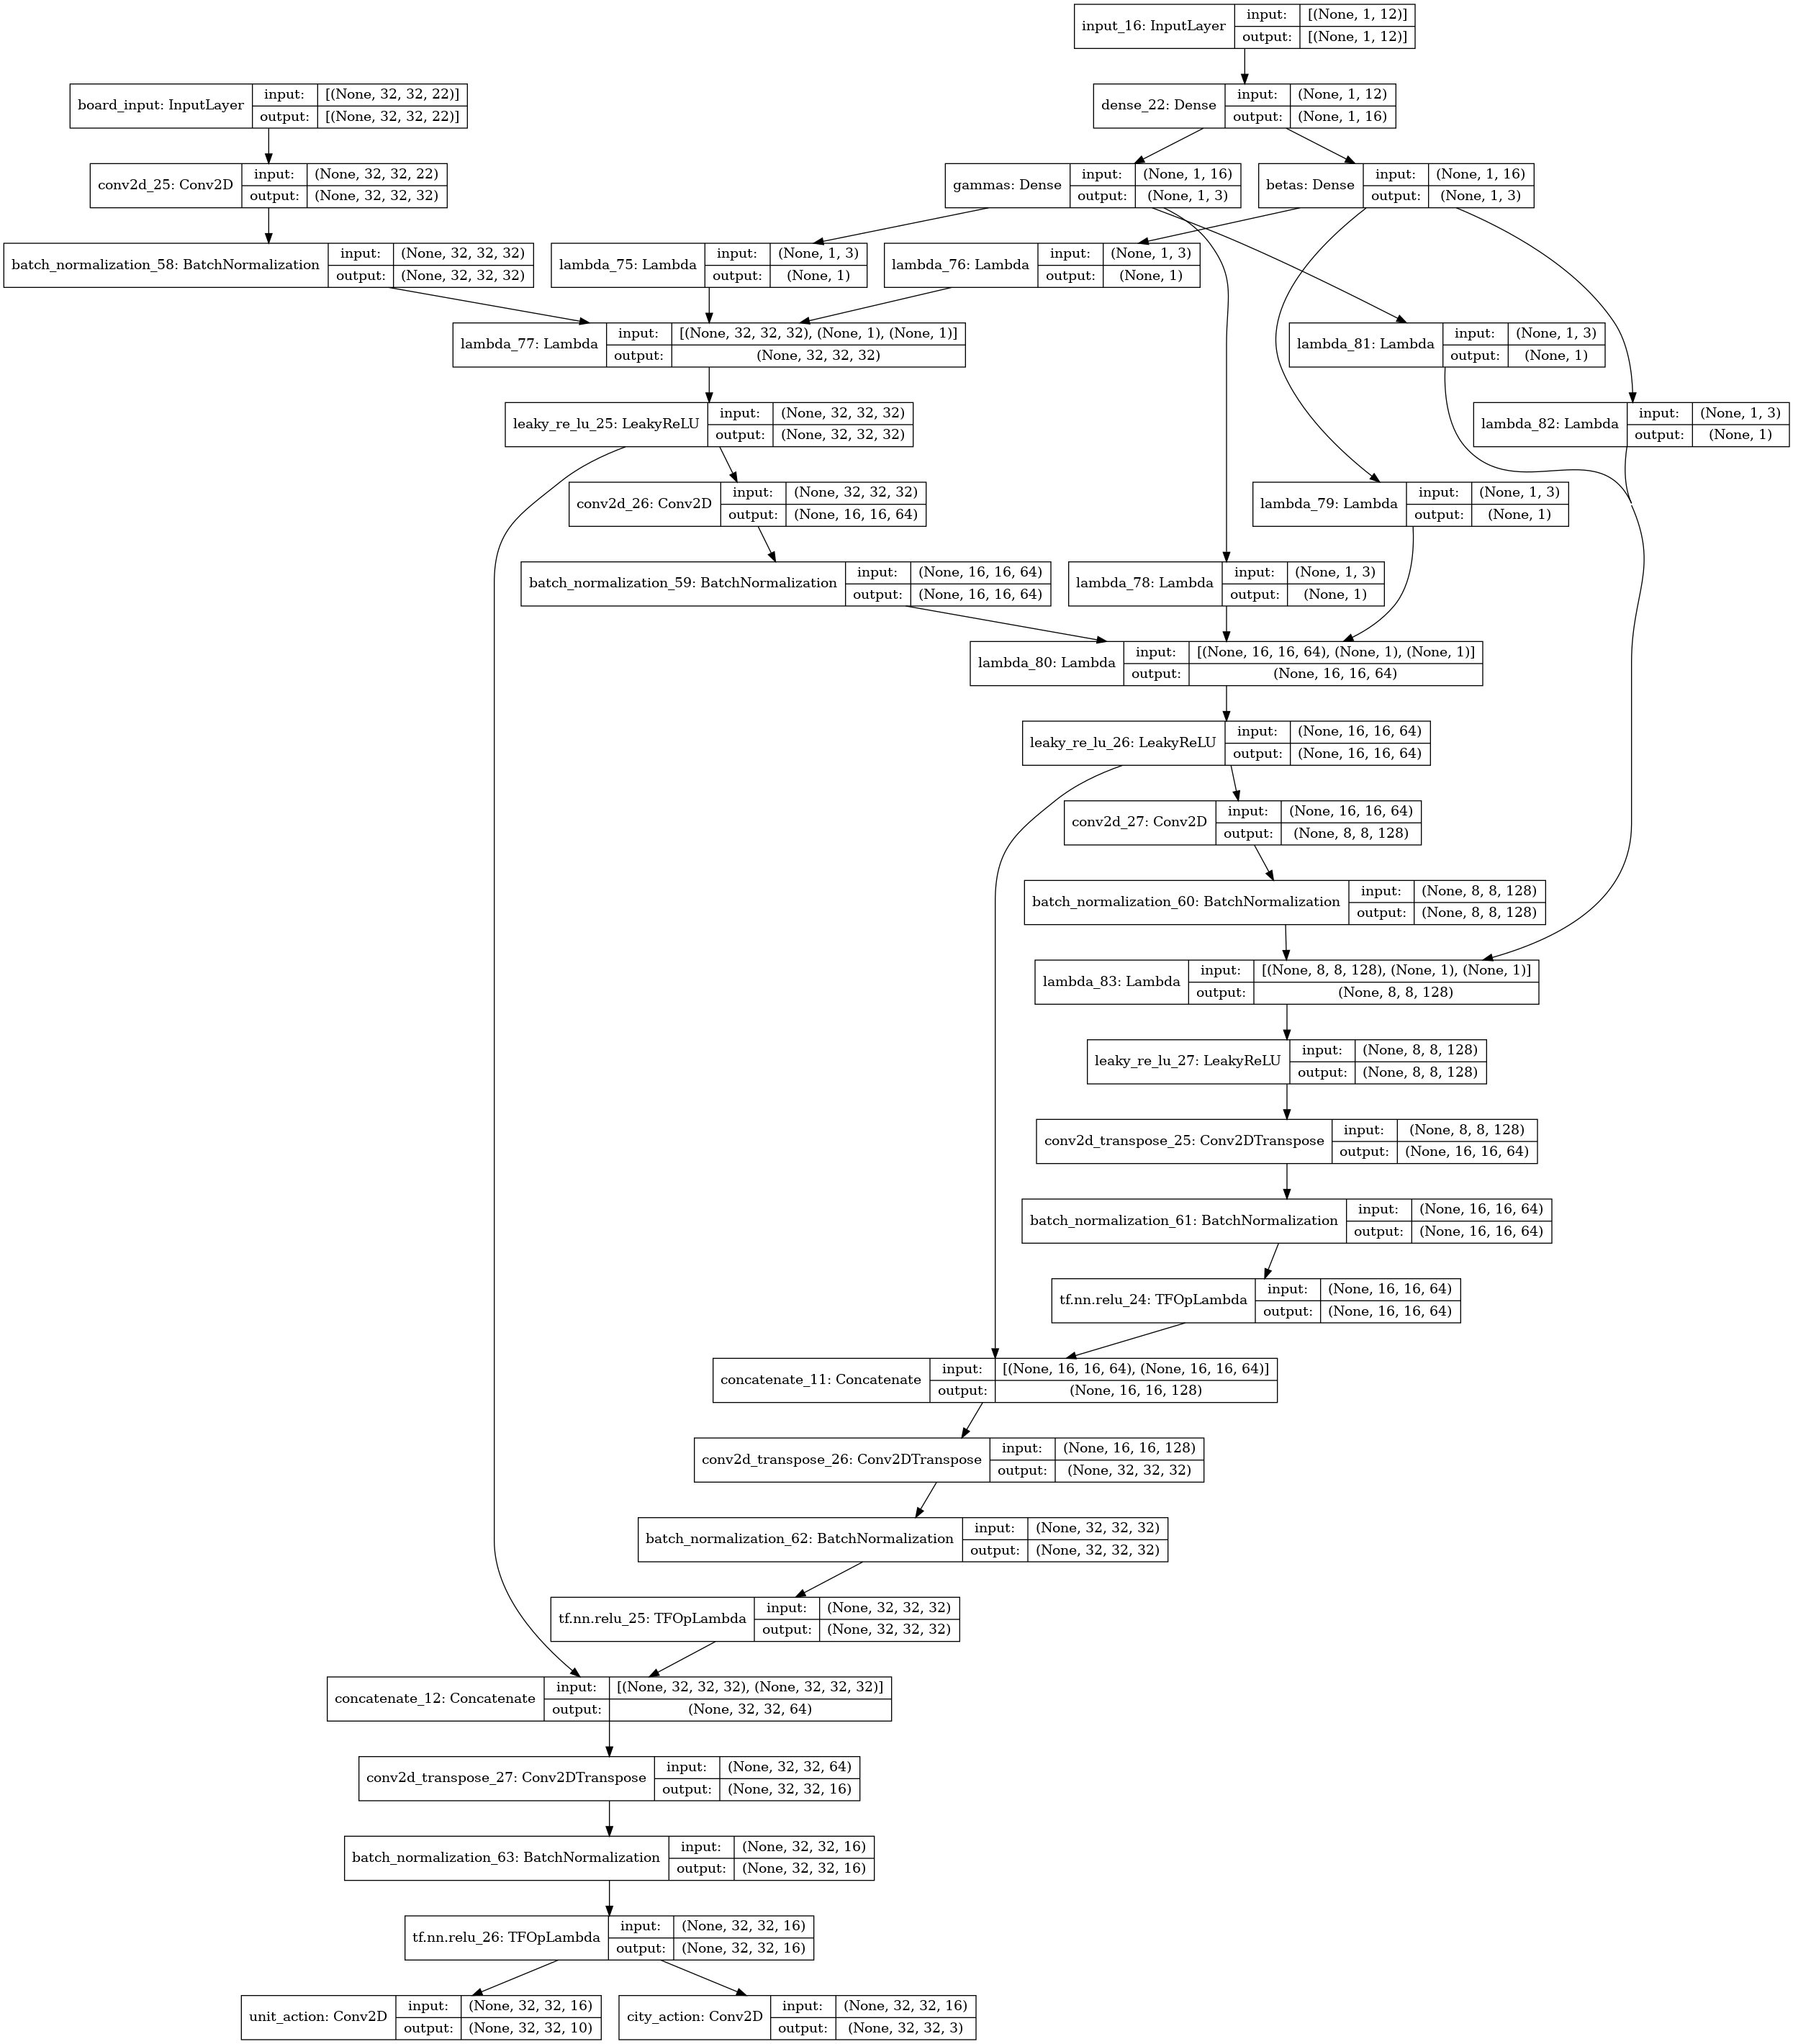

In [33]:
# Unet parameters
config.INPUT_SHAPE = [32, 32, 22] #[512, 128, 1]
config.FILTERS_LAYER_1 = 32 # 16
config.N_LAYERS = 3 # 6
config.ACT_LAST = 'sigmoid' # sigmoid
# Condition parameters
config.Z_DIM = 12 # 4
config.CONTROL_TYPE = 'dense' # dense
config.FILM_TYPE = 'simple' # simple
config.N_NEURONS = [16] # [16, 64, 256]
config.N_CONDITIONS = config.N_LAYERS # 6 this should be the same as the number of layers


model = cunet_luxai_model(config)
model.summary(line_length=150)
keras.utils.plot_model(model, show_shapes=True)

TODO: verify that the custom loss works

In [34]:
[ret.shape for ret in model.predict([np.zeros((1, 32, 32, 22)), np.ones((1, 1, 12))])]

[(1, 32, 32, 10), (1, 32, 32, 3)]

In [ ]:
keras.backend.binary_crossentropy

In [10]:
config.FILTERS_LAYER_1

32

In [11]:
config.N_NEURONS

[16, 64, 256]

In [12]:
config.N_CONDITIONS

3

In [13]:
config.ACT_LAST

'sigmoid'

In [14]:
import pydot